In [1]:
import numpy as np
import time
from scipy import misc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import math
import pandas as pd
#import cvxpy as cp
from scipy.optimize import fsolve
import torch.optim.lr_scheduler as lr_scheduler

In [2]:
M=1000
ite=10
dim_n=5
T=1
T_C=1
T_F=0.1
delta_c = torch.tensor(T_C/ite)
delta_f=torch.tensor(T_F/ite)
print(delta_c,delta_f)
#delta=torch.tensor(0.01)
sigma=0.1
sigma1=1e-3
sigma2=1e-2
theta1=1
theta2=1
mu1=1e-2#kappa
mu2=5 #rho
A0=0.0
gamma=0.0
X0=10000
neuron_model_psi=20

tensor(0.1000) tensor(0.0100)


In [3]:
model_f= torch.nn.Sequential(
    torch.nn.Linear(dim_n, neuron_model_psi),
    torch.nn.ReLU(),
    #torch.nn.Linear(neuron_model_psi, neuron_model_psi),
    #torch.nn.ReLU(),
    # torch.nn.Linear(neuron_model_psi, neuron_model_psi_2),
    # torch.nn.ReLU(),
    torch.nn.Linear(neuron_model_psi, neuron_model_psi),
    torch.nn.ReLU(),
    torch.nn.Linear(neuron_model_psi,1)
)

In [4]:
#torch.save(model, 'model_N10.pth')
model_coarse = torch.load('LOB_stoc_N10.pth')
#model_coarse.eval()(c)

In [5]:
def kappa_rho_sim(M,ite,theta1,mu1,sigma1,theta2,mu2,sigma2,delta):
    kappa=torch.zeros([M,ite+1])
    kappa[:,0]=mu1
    rho=torch.zeros([M,ite+1])
    rho[:,0]=mu2

    for i in range (1,ite+1):
        kappa[:,i]=kappa[:,i-1]+theta1*(mu1-kappa[:,i-1])*delta+np.sqrt(delta)*sigma1*np.random.rand(M)  # Xn+1=Xn+θ(μ−Xn)Δt+σΔWn
        rho[:,i]=rho[:,i-1]+theta2*(mu2-rho[:,i-1])*delta+np.sqrt(delta)*sigma2*np.random.rand(M)
    return kappa,rho

In [6]:
def update(x3,psi,i,delta,kappa,rho):
  t=x3[:,0]+delta
  kap=kappa[:,i+1]
  rh=rho[:,i+1]
#   kappa=x3[:,3]+theta1*(mu1-x3[:,3])*delta+torch.sqrt(delta)*sigma1*W1[i]
#   rho=x3[:,4]+theta2*(mu2-x3[:,4])*delta+torch.sqrt(delta)*sigma1*W2[i]
  D = (x3[:,1]+kap*psi)*torch.exp(-rh*delta)
  #print('d',D.shape)
  R= x3[:,2]-psi
  #print(kappa.shape,rho.shape)
  up=torch.cat((t.unsqueeze(1),D.unsqueeze(1),R.unsqueeze(1),kap.unsqueeze(1),rh.unsqueeze(1)),dim=1)
  return up

def loss_func(x2,psi):
  loss=(x2[:,1]*psi+(x2[:,3]/2.0)*torch.pow(psi,2))
  #print('loss',loss.shape)
  return loss

def unit(x1,model,i,delta,kappa,rho):
    psi=model(x1).squeeze(1)
    los=loss_func(x1,psi)
    upd=update(x1,psi,i,delta,kappa,rho)
    #print(upd)
    return psi,los,upd

def loss_func_total(u,model,delta,kappa,rho):
  loss=torch.zeros(M,ite)
  psi=torch.zeros(M,ite)
  for i in range(ite+1):
    if(i!=ite):
      psi_run,loss_run,u_run=unit(u,model,i,delta,kappa,rho)
      #print('los func=',psi_run.shape,loss_run.shape)
      loss[:,i]=loss_run
      #print(loss)
      psi[:,i]=psi_run
      #print(psi)
      u=u_run
      #print(u)
    else:
      #print(torch.sum(psi,dim=1),R.squeeze(1))
      psi_ter=R.squeeze(1)-torch.sum(psi,dim=1)
      loss_ter=loss_func(u,psi_ter)
      #print('ter',loss_ter.shape)
  #print(torch.sum(loss,dim=1))
  loss=torch.sum(loss,dim=1)+loss_ter
  #print(loss.shape)
  return torch.mean(loss)


In [7]:
# kappa,rho=kappa_rho_sim(M,ite,theta1,mu1,sigma1,theta2,mu2,sigma2,delta_f) 
# print(kappa,rho)

In [8]:
def testing_coarse(X0,M1): 
    t_test=torch.zeros([M1,1])
    D_test=torch.zeros([M1,1])
    #D_test=torch.FloatTensor(M,1).uniform_(0.1,0.5)   #Price impact D_t
    #R_test=torch.FloatTensor(M1,1).uniform_(50,100)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
    R_test=torch.linspace(X0*0.95, X0*1.05, steps=M1).unsqueeze(1)
    kappa,rho=kappa_rho_sim(M1,ite,theta1,mu1,sigma1,theta2,mu2,sigma2,delta_c)
    #(M,ite,theta1,mu1,sigma1,theta2,mu2,sigma2)
    x_test=torch.cat((t_test,D_test,R_test,kappa[:,0].unsqueeze(1),rho[:,0].unsqueeze(1)),dim=1)
    print('Input=',x_test,'\n')
    a=torch.zeros(M1,ite+1)
    #print(a.shape)
    for i in range(ite+1):
      if(i!=ite):
        #print(x_test)
        soln_pred=model_coarse.eval()(x_test).squeeze(1).detach()
        a[:,i]=soln_pred
        x_test=update(x_test,soln_pred,i,delta_c,kappa,rho)
        #print(x_test,'\n')
      else:
        a[:,i]=R_test.squeeze(1)-torch.sum(a,dim=1)
        
    return x_test,a

# x1=R_test.squeeze().numpy()
# c_pred=np.zeros(M1)

# for i in range(M1):
#   print('size of total order=',x1[i])


#   print('predicted soln=',a[i,:],'sum of all execution=',torch.sum(a[i,:]).detach())
#   #pred_cost=cost(a[i,:].detach().numpy())
# #   print('predicted cost=',pred_cost,'\n')

In [9]:
x_c,c_soln=testing_coarse(X0,5)
# print(x_c,c_soln,torch.sum(a,1))
D_max=torch.max(x_c[:,1])
R_min=torch.min(c_soln)
R_max=torch.max(c_soln)
t=torch.zeros([M,1])
kappa,rho=kappa_rho_sim(M,ite,theta1,mu1,sigma1,theta2,mu2,sigma2,delta_f) 
D=torch.FloatTensor(M,1).uniform_(0.0,D_max)
#D=torch.FloatTensor(M,1).uniform_(0.1,0.5)   #Price impact D_t
R=torch.FloatTensor(M,1).uniform_(R_min,R_max)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
x=torch.cat((t,D,R,kappa[:,0].unsqueeze(1),rho[:,0].unsqueeze(1)),dim=1)
print('coarse soution=',c_soln)
print(x)

Input= tensor([[0.0000e+00, 0.0000e+00, 9.5000e+03, 1.0000e-02, 5.0000e+00],
        [0.0000e+00, 0.0000e+00, 9.7500e+03, 1.0000e-02, 5.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+04, 1.0000e-02, 5.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0250e+04, 1.0000e-02, 5.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0500e+04, 1.0000e-02, 5.0000e+00]]) 

coarse soution= tensor([[1874.8254,  729.2501,  689.4294,  702.6276,  695.3053,  687.5288,
          682.6673,  665.8235,  635.4273,  615.2198, 1521.8950],
        [1911.3599,  749.7101,  703.8429,  717.6811,  703.8499,  696.0662,
          692.9988,  678.5549,  642.4676,  626.6368, 1626.8320],
        [1947.8948,  761.8751,  708.7725,  725.2099,  720.7411,  719.4257,
          712.9943,  699.9573,  657.9555,  637.7051, 1707.4688],
        [1984.4292,  786.5870,  722.9830,  733.3105,  730.5060,  720.2004,
          713.2435,  710.6334,  666.7548,  647.1489, 1834.2031],
        [2020.9631,  792.3704,  734.4494,  729.5286,  737.6015, 

In [10]:
start=time.time()
lr1 = 8e-3
max_epoch = 15000
optimizer = optim.Adam(model_f.parameters(), lr1)

#print(psi.shape)
for epoch in range(max_epoch):
  optimizer.zero_grad()
  cost=loss_func_total(x,model_f,delta_f,kappa,rho)
  cost.backward()
  optimizer.step()
  #print(loss.item())
  if (epoch % 100==0):
    print("At epoch {} the mean cost is {}.".format(epoch,cost.detach()))
end=time.time()
print('time elapsed=',end-start)

At epoch 0 the mean cost is 16495.9296875.
At epoch 100 the mean cost is 13982.9150390625.
At epoch 200 the mean cost is 13973.8701171875.
At epoch 300 the mean cost is 13847.68359375.
At epoch 400 the mean cost is 13806.982421875.
At epoch 500 the mean cost is 13802.798828125.
At epoch 600 the mean cost is 13801.96875.
At epoch 700 the mean cost is 13801.7099609375.
At epoch 800 the mean cost is 13801.779296875.
At epoch 900 the mean cost is 13801.3642578125.
At epoch 1000 the mean cost is 13802.185546875.
At epoch 1100 the mean cost is 13801.0537109375.
At epoch 1200 the mean cost is 13801.33203125.
At epoch 1300 the mean cost is 13800.744140625.
At epoch 1400 the mean cost is 13800.5908203125.
At epoch 1500 the mean cost is 13800.6630859375.
At epoch 1600 the mean cost is 13802.2138671875.
At epoch 1700 the mean cost is 13800.10546875.
At epoch 1800 the mean cost is 13799.9482421875.
At epoch 1900 the mean cost is 13799.994140625.
At epoch 2000 the mean cost is 13799.59765625.
At ep

In [11]:
model_fin=model_f

In [12]:
coarse_soln=c_soln[2].numpy()
print('coarse soln',coarse_soln, 'Total=',np.sum(coarse_soln))

coarse soln [1947.8948   761.8751   708.7725   725.2099   720.7411   719.4257
  712.99426  699.9573   657.9555   637.70514 1707.4688 ] Total= 10000.0


In [13]:
def update_pred(x3,psi,i,delta,kappa,rho):
  t=x3[:,0]+delta
  kap=kappa[i+1].reshape(1)
  rh=rho[i+1].reshape(1)
  D = (x3[:,1]+kap*psi)*torch.exp(-rh*delta)
  R= x3[:,2]-psi
  #print(t.shape,D.shape,R.shape,kap.shape,rh.shape)
  up=torch.cat((t.unsqueeze(1),D.unsqueeze(1),R.unsqueeze(1),kap.unsqueeze(1),rh.unsqueeze(1)),dim=1)
  return up

In [14]:
def testing_fine_first_last(c_soln,ite):    
    f_soln=[]
    c=c_soln[2]
    x_test=torch.tensor([[0.0,0.0,c[0],1e-2,5.000]])
    x_test[0,2]=x_test[0,2]+c[ite]
    for i in range(ite):       
        if (i!=0):
            x_test[0,2]=x_test[0,2]+c[i] #Adding previous remaining balance to the current balance         
        for j in range(ite):
            #print(i,x_test)
            soln_pred=model_fin.eval()(x_test).squeeze(1).detach()
            f_soln.append(soln_pred)
            #print(soln_pred.shape)
            x_test=update_pred(x_test,soln_pred,j,delta_f,kappa[1,],rho[1,])
            #print(x_test[0,2])
    f_soln.append(x_test[0,2].view(1))
    f_soln= np.array([tensor.numpy() for tensor in f_soln]).reshape(len(f_soln))
    return x_test,f_soln

In [15]:
data,fine_soln=testing_fine_first_last(c_soln,ite)
D_N=data[0,2].detach().numpy()

print('\nFine solution=', fine_soln,'Total=',np.sum(fine_soln))



Fine solution= [1663.9427     92.791534   55.877182   57.16693    56.30168    55.704254
   55.168533   54.409714   53.821228   53.25151   439.94168    41.886673
   62.81842    60.65013    59.895462   59.19847    58.582703   57.728943
   57.06018    56.410004  416.04285    45.753693   65.09386    62.950317
   62.129654   61.379654   60.71306    59.800156   59.080833   58.381264
  426.32153    47.424103   67.1781     64.952095   64.08079    63.283035
   62.572296   61.608406   60.844513   60.10154   425.7317     49.163673
   68.74546    66.48434    65.57199    64.738785   63.994003   62.99115
   62.193344   61.391678  426.37524    50.46111    69.97221    67.676346
   66.70778    65.8477     65.07599    75.99826    69.08702    44.95584
  348.05707   130.32144    78.76805    80.500916   51.557644   37.837288
   29.651365   24.218016   20.476706   19.509563  311.80072   154.61699
   80.68938    52.26062    39.22385    30.67615    26.168337   24.964685
   23.879467   22.971853  279.62048   

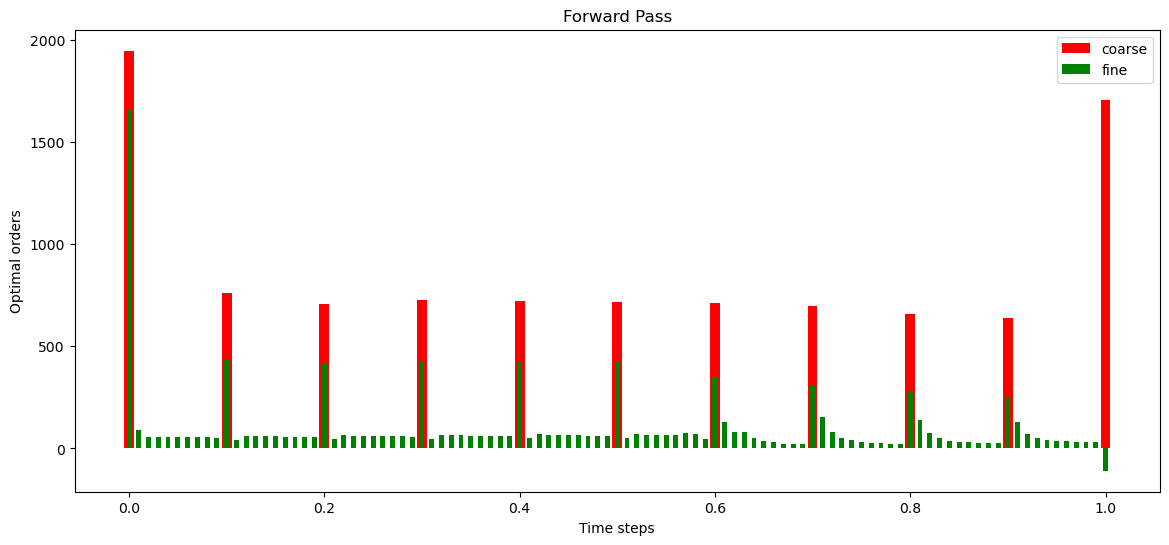

In [16]:
t_step1=np.linspace(0,1,num=11)
t_step2=np.linspace(0,1,num=101)
plt.figure(figsize=(14,6))
plt.bar(t_step1,coarse_soln,color='red',width=0.01,label='coarse')
plt.bar(t_step2,fine_soln,color='green',width=0.005,label='fine')
plt.xlabel('Time steps')
plt.ylabel('Optimal orders')
plt.title('Forward Pass')
plt.legend()
plt.show()